# Start cuda

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Loading requirements

In [2]:
! pip install datasets

     |████████████████████████████████| 163kB 8.5MB/s 
     |████████████████████████████████| 17.7MB 1.3MB/s 
     |████████████████████████████████| 245kB 53.8MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [3]:
! pip install transformers

     |████████████████████████████████| 1.4MB 7.9MB/s 
     |████████████████████████████████| 890kB 39.3MB/s 
     |████████████████████████████████| 2.9MB 28.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3090d106b83fa0aae7be287791a70e8229560f8dcb6120a6f8f7c00dd066f228
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# Import things to get data to work
from datasets import load_from_disk
import sys
import os

# Loading data

In [5]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
sys.path.append(os.path.join('/content/drive/My Drive/deep_learning_project'))
train_path = 'drive/My Drive/deep_learning_project/all_data/train_all'
val_path = 'drive/My Drive/deep_learning_project/all_data/validation_all'

In [7]:
train_data = load_from_disk(train_path)
validation_data = load_from_disk(val_path)

FileNotFoundError: ignored

In [24]:
print(train_data[0])

{'answer': 'york', 'paragraph': 'judi dench born in dorset and later moved to dublin where he was raised he met dench s mother while he was studying medicine at trinity college dublin dench attended the mount school a quaker independent secondary school in york and became a quaker her brothers one of whom was actor jeffery dench were born in tyldesley lancashire her niece emma dench is a roman historian and professor previously at birkbeck university of london and currently at harvard university career in britain dench has developed a reputation as one of the greatest actresses of the post war period primarily through her work in theatre which has been her forte throughout her career she has more than once been named number one in polls for britain s best actor early years', 'question': 'Where in England was Dame Judi Dench born?', 'question_id': 'tc_3'}


# Preparing data for modelling

In [25]:
from math import ceil
import torch
from transformers import AutoTokenizer, BertModel, AdamW, BertForSequenceClassification

In [26]:
def get_loss(sim):
    nll = -(torch.diagonal(sim) - torch.logsumexp(sim, dim = 1))
    return sum(nll)# return negative loss

In [31]:
# Define data parameters
batch_size = 100

# Train
n_sample_train = ceil(len(train_data)*0.02) 
n_batches_train = ceil(n_sample_train/batch_size)
# Validation
n_sample_validation = ceil(len(validation_data)*0.05)
n_batches_validation = ceil(n_sample_validation/batch_size)


# Define model parameters
lr = 5e-5
n_epochs = 4

# Define printing parameters
n_batch_print = 50 # Prints every (n_batch_print) during training

In [32]:
print(n_sample_validation)
print(n_sample_train)

826
2503


In [33]:
# NB CHANGE THIS CELL WHEN THE DATA IS READY###############
# Subset data
train_data = train_data.select(range(n_sample_train))
validation_data = validation_data.select(range(n_sample_validation))

# Tokenize data
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', padding = True)
train_data = train_data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'], padding = 'max_length')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'max_length')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'max_length')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'], padding = 'max_length')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'], padding = 'max_length')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'], padding = 'max_length')['token_type_ids']},
    batched = True, batch_size= batch_size)

validation_data = validation_data.map(lambda example: {
    'Q_input_ids': tokenizer(example['question'], padding = 'max_length')['input_ids'],
    'Q_attention_mask': tokenizer(example['question'], padding = 'max_length')['attention_mask'],
    'Q_token_type_ids': tokenizer(example['question'], padding = 'max_length')['token_type_ids'],
    'P_input_ids': tokenizer(example['paragraph'], padding = 'max_length')['input_ids'],
    'P_attention_mask': tokenizer(example['paragraph'], padding = 'max_length')['attention_mask'],
    'P_token_type_ids': tokenizer(example['paragraph'], padding = 'max_length')['token_type_ids']},
    batched = True, batch_size= batch_size)

#%% Change to pytorch format. 
train_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])

validation_data.set_format(type = 'torch', 
                        columns = ['Q_input_ids', 'Q_attention_mask', 'Q_token_type_ids',
                                   'P_input_ids', 'P_attention_mask', 'P_token_type_ids'])

# Training model

In [34]:
# Get pretrained model
model = BertModel.from_pretrained('bert-base-uncased')
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

#Freezing all parameters except the last ones (I think - double check this)
param_to_be_optimized = ['pooler.dense.weight', 'pooler.dense.bias']
for name, param in model.named_parameters():
  #print(name)
  if not name in param_to_be_optimized:
    param.requires_grad = False

# --------- From Hugging Face ---------------
#for name, param in model.base_model.named_parameters():
#  param.requires_grad = False
  #if(param.requires_grad): 
   # print(name)
#for name, param in model.named_parameters():
#  if(param.requires_grad): 
#    print(name)
# -----------------------------------------

# Checking we have frozen the right layers 
for name, param in model.named_parameters():
  if(param.requires_grad): 
    print(name)

# Move model to cuda to train there
model.to(device)

optim = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = lr) # filter object works as a generator 

pooler.dense.weight
pooler.dense.bias


In [35]:
# ADAM gets the correct bias and weigths
optim.param_groups[0]['params'][1].size()

torch.Size([768])

In [16]:
# Printing layers in model to compare 
#model

In [36]:
# Print the weights that are being updated
for name, param in model.named_parameters():
  if param.requires_grad:
    print(name)

pooler.dense.weight
pooler.dense.bias


In [37]:
# The big loop :D 
epoch_train_loss = [None]*n_batches_train
epoch_validation_loss = [None]*n_batches_validation
train_loss = [None]*n_epochs
validation_loss = [None]*n_epochs


for epoch in range(n_epochs):
    
    print(f'### EPOCH: {epoch+1}/{n_epochs} ###')

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    trainloader = iter(trainloader)
    validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    validationloader = iter(validationloader)
    
    # TRAINING MODEL
    model.train()
    for i, batch in enumerate(trainloader):
        if i % n_batch_print == 0:
          print(f'batch {i+1}/{len(trainloader)}')
        
        model.zero_grad()

        # Make forward pass for paragraphs
        input_ids = batch['P_input_ids'].to(device)
        attention_mask = batch['P_attention_mask'].to(device)
        token_type_ids = batch['P_token_type_ids'].to(device)
        P_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)#[0][:, 0, :]
        
        P_cat_hidden = torch.cat(tuple([P_encoded_layers.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
        P_cat_hidden = P_cat_hidden[:, 0, :]
        P_cat_hidden = self.dropout(P_cat_hidden)
    
        # Make forward pass for questions
        input_ids = batch['Q_input_ids'].to(device)
        attention_mask = batch['Q_attention_mask'].to(device)
        token_type_ids = batch['Q_token_type_ids'].to(device)
        Q_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)#[0][:, 0, :]
        
        Q_cat_hidden = torch.cat(tuple([Q_encoded_layers.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
        Q_cat_hidden = Q_cat_hidden[:, 0, :]
        Q_cat_hidden = self.dropout(Q_cat_hidden)
    
    
    
        # Calculate similarity matrix
        sim_matrix = torch.matmul(Q_encoded_layers.pooler_output, P_encoded_layers.pooler_output.T)
        
        # Get loss
        loss = get_loss(sim_matrix)
        #loss.requires_grad = True

        # Update weights
        loss.backward()
        optim.step()

        # Save loss
        epoch_train_loss[i] = loss.item()

    # VALIDATING MODEL
    #model.eval()
    for i, batch in enumerate(validationloader):
        
        # (get extra observation in training set)

        # Make forward pass for paragraphs
        input_ids = batch['P_input_ids'].to(device)
        attention_mask = batch['P_attention_mask'].to(device)
        token_type_ids = batch['P_token_type_ids'].to(device)
        P_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)#[0][:, 0, :]
        
        P_cat_hidden = torch.cat(tuple([P_encoded_layers.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
        P_cat_hidden = P_cat_hidden[:, 0, :]
        P_cat_hidden = self.dropout(P_cat_hidden)
    

        # Make forward pass for questions
        input_ids = batch['Q_input_ids'].to(device)
        attention_mask = batch['Q_attention_mask'].to(device)
        token_type_ids = batch['Q_token_type_ids'].to(device)
        Q_encoded_layers = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)#[0][:, 0, :]
        
        Q_cat_hidden = torch.cat(tuple([Q_encoded_layers.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
        Q_cat_hidden = Q_cat_hidden[:, 0, :]
        Q_cat_hidden = self.dropout(Q_cat_hidden)
    
    
        # Calculate similarity matrix
        sim_matrix = torch.matmul(Q_cat_hidden, P_cat_hidden.T)
        
        # Get loss
        loss = get_loss(sim_matrix)
        epoch_validation_loss[i] = loss.item()
        
    
    train_loss[epoch] = sum(epoch_train_loss)/len(epoch_train_loss)
    validation_loss[epoch] = sum(epoch_validation_loss)/len(epoch_validation_loss)
    
    print(f'train loss: {train_loss[epoch]:.2f}')
    print(f'validation loss: {validation_loss[epoch]:.2f}')
    




### EPOCH: 1/4 ###
batch 1/26
train loss: 7778.78
validation loss: 6636.42
### EPOCH: 2/4 ###
batch 1/26
train loss: 5567.85
validation loss: 4722.92
### EPOCH: 3/4 ###
batch 1/26
train loss: 4398.87
validation loss: 3546.99
### EPOCH: 4/4 ###
batch 1/26
train loss: 3339.07
validation loss: 2978.53


In [60]:
#Q_encoded_layers.shape
#batch.keys()
#batch["Q_input_ids"].shape
#tmp = model(input_ids=input_ids, 
#                          attention_mask=attention_mask, 
#                          token_type_ids=token_type_ids)

#print(tmp.pooler_output.size())
#print(Q_encoded_layers.shape)
#tmp.last_hidden_state.size()

tmp = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          token_type_ids=token_type_ids, output_hidden_states = True)

hej = torch.cat(tuple([tmp.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
hej = hej[:, 0, :]
hej = self.dropout(hej)
hej.size()

torch.Size([26, 512, 3072])

In [ ]:
model

In [ ]:
print(validation_loss)
print(train_loss)

In [ ]:
#%% Saving model
model_path = 'drive/My Drive/BERT_Model/8_percent/'
model.save_pretrained(model_path)

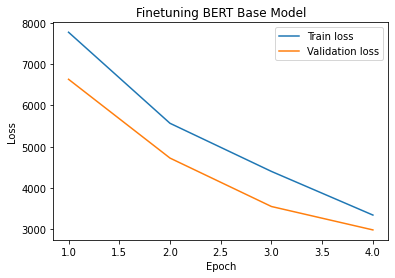

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(range(1, n_epochs+1), train_loss, label = 'Train loss')
plt.plot(range(1, n_epochs+1), validation_loss, label = 'Validation loss')
plt.title('Finetuning BERT Base Model')
plt.ylabel('Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()
fig.savefig("drive/My Drive/deep_learning_project/figures/BERTbaseFinetuning_pooled_output.pdf", bbox_inches='tight')

In [ ]:
validation_loss
train_loss

In [ ]:
print(validation_loss)

In [ ]:
print(train_loss)

In [ ]:
# Andreas' code he ask us to run on slack 
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)